In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3399, done.
remote: Counting objects: 100% (670/670), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 3399 (delta 577), reused 507 (delta 424), pack-reused 2729 (from 1)
Receiving objects: 100% (3399/3399), 233.26 MiB | 10.86 MiB/s, done.
Resolving deltas: 100% (2627/2627), done.
Updating files: 100% (144/144), done.


In [2]:
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install pymoo -q

Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.6/724.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00


In [3]:
!pip install scipy==1.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 645.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
cvxpy 1.6.4 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, b

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

import torch


import warnings
warnings.filterwarnings("ignore")



from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination

from pymoo.optimize import minimize

from pymoo.indicators.hv import Hypervolume

In [22]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  inputs = inputs.reshape(1,-1)
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])#not in study 1
    snd.mvr_t1_chi2(x[3])#not in study 1
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])#not in study 1
    snd.mvr_t4_chi2(x[7])#not in study 1

    # snd.mvr_t1_th1(x[0])
    # snd.mvr_t1_th2(x[1])
    # snd.mvr_t4_th1(x[2])
    # snd.mvr_t4_th2(x[3])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()

    result.append([(my_intensity)/(61441), do_centroid*1e6])
    del snd
  return np.array(result)


In [25]:
input = np.ones((1,8)) * 0.55
get_snd_outputs(input)

array([[ 1.15907167, 80.90626893]])

In [57]:
class MyProblem(ElementwiseProblem):
  def __init__(self):
    super().__init__(n_var=8,
                      n_obj=2,
                      n_ieq_constr=0,
                      xl=np.ones(8)*0.3,
                      xu=np.ones(8)*0.7)

  def _evaluate(self, x, out, *args, **kwargs):
    f1, f2 = get_snd_outputs(x).squeeze()

    out["F"] = [-f1, f2/100]

In [58]:
problem = MyProblem()

In [59]:
algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [60]:
termination = get_termination("n_gen", 100)

In [61]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      4 |             - |             -
     2 |      300 |      3 |  0.0762101807 |             f
     3 |      400 |      3 |  0.000000E+00 |             f
     4 |      500 |      3 |  0.1514671086 |         ideal
     5 |      600 |      4 |  0.1379433896 |             f
     6 |      700 |      4 |  0.0401279985 |             f
     7 |      800 |      5 |  0.0518365645 |         ideal
     8 |      900 |      5 |  0.0083096289 |             f
     9 |     1000 |      6 |  0.0003468514 |             f
    10 |     1100 |      5 |  0.0199348300 |         ideal
    11 |     1200 |      5 |  0.2718604859 |         ideal
    12 |     1300 |      5 |  0.000000E+00 |             f
    13 |     1400 |      6 |  0.2205050707 |         ideal
    14 |     1500 |      4 |  0.0275988298 |             f
    15 |     1600 |      5 |  0.0176766200 |             f
    16 |     1700 |      6 |  0.1943698293 |         nad

In [62]:
X = res.X
F = res.F

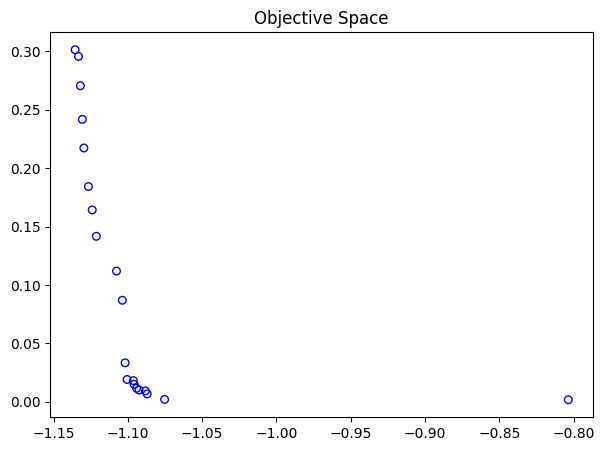

In [63]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

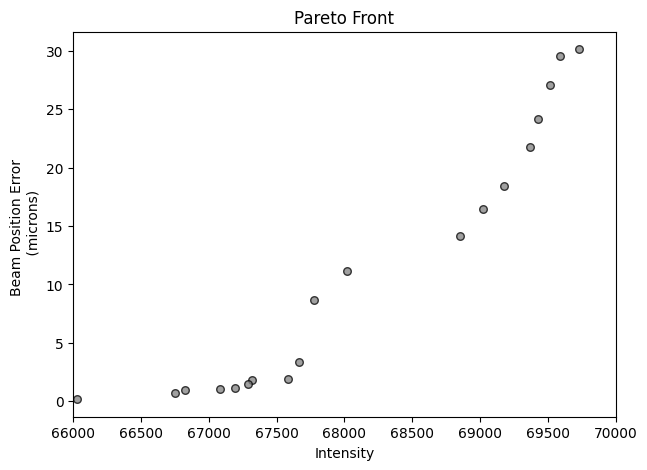

In [67]:
intensity = -F[:, 0]
BPE = F[:, 1] * 100
plt.figure(figsize=(7, 5))
plt.scatter(intensity*61411, BPE, s=30, facecolors='gray', edgecolors='k', alpha=0.75)
plt.ylabel("Beam Position Error \n (microns)")
plt.xlabel("Intensity")
plt.xlim(66000, 70000)

plt.title("Pareto Front")
plt.show()

In [65]:
F

array([[-1.09241874,  0.01008898],
       [-1.08691042,  0.00676653],
       [-0.80352603,  0.00172798],
       [-1.09624799,  0.01812799],
       [-1.10369963,  0.08692776],
       [-1.08812217,  0.009302  ],
       [-1.12958496,  0.21727953],
       [-1.10049097,  0.01909298],
       [-1.12394123,  0.16424903],
       [-1.09573718,  0.01502527],
       [-1.07523876,  0.00207911],
       [-1.13319974,  0.29566571],
       [-1.09410931,  0.01153803],
       [-1.10761907,  0.1119047 ],
       [-1.13545916,  0.30134807],
       [-1.13059824,  0.24177541],
       [-1.13193716,  0.27055729],
       [-1.12118634,  0.14167518],
       [-1.10180967,  0.03337031],
       [-1.12651107,  0.18423971]])